In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime

In [22]:
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series.dropna())
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] < 0.05:
        print("p-value < 0.05. Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("p-value >= 0.05. Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [3]:
# load dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m')

In [4]:
milk = pd.read_csv("milk.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
milk

,Milk
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


<AxesSubplot:xlabel='Month'>

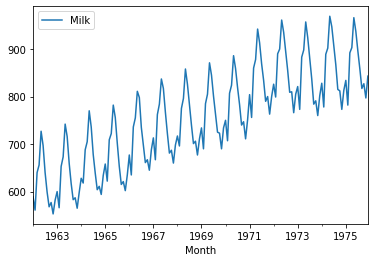

In [5]:
milk.plot()

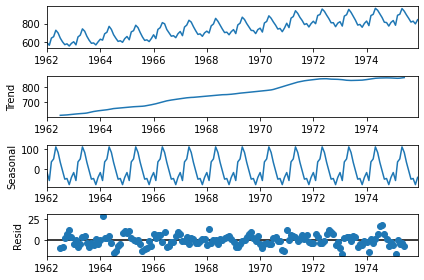

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(milk)
decomposed.plot()
plt.show()

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


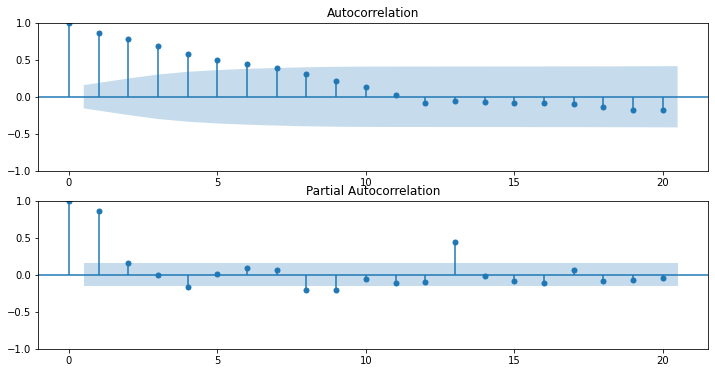

In [29]:
# Stationary data
month_diff = milk.diff(12).dropna()
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(month_diff, ax=ax[0], lags=20)
ax[1] = plot_pacf(month_diff, ax=ax[1], lags=20)

In [24]:
adf_check(month_diff)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359397
p-value : 0.16079880527711382
Number of Lags Used : 12
Number of Observations Used : 143
p-value >= 0.05. Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


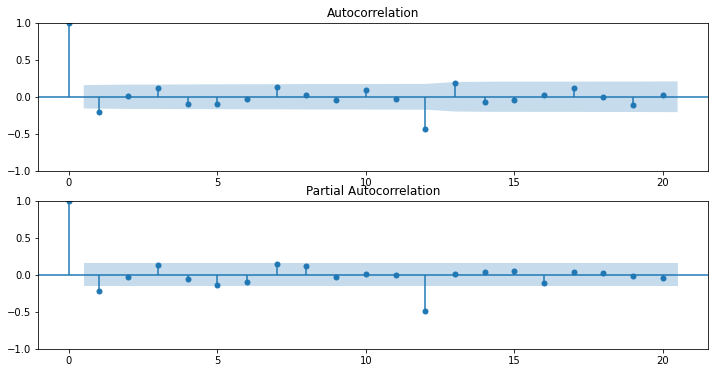

In [21]:
month_first_diff = milk.diff(12).diff().dropna()
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(month_first_diff, ax=ax[0], lags=20)
ax[1] = plot_pacf(month_first_diff, ax=ax[1], lags=20)

In [25]:
adf_check(month_first_diff)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921979
p-value : 1.865423431878876e-05
Number of Lags Used : 11
Number of Observations Used : 143
p-value < 0.05. Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
